In [97]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling

from sklearn.ensemble import RandomForestRegressor
import xgboost as xg

from sklearn.model_selection import train_test_split
import stats
from pandas import datetime

<ipython-input-97-cc39d131a0d4>:12: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [98]:
train = pd.read_csv("TRAIN.csv",parse_dates=True)
test = pd.read_csv("TEST_FINAL.csv",parse_dates=True)

In [99]:
train['Date'] =  pd.to_datetime(train['Date'])
# train.set_index("Date",inplace=True)
train.head(2)

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12


In [100]:
#Leaving date and label column out of category encoding
y = train[["Sales","Date"]]
train_new = train.drop(["Sales","Date","ID"],axis=1)

y1 = test[["Date"]]
test_new = test.drop(["Date","ID"],axis=1)

In [101]:
train_new.head(2)

,Store_id,Store_Type,Location_Type,Region_Code,Holiday,Discount,#Order
0,1,S1,L3,R1,1,Yes,9
1,253,S4,L2,R1,1,Yes,60


In [102]:
#We have 2 types of data in our dataset : int64 and object

train_categorical = train_new.select_dtypes(exclude = ['int64'])
test_categorical = test_new.select_dtypes(exclude = ['int64'])

train_numerical = train_new.select_dtypes(include = ['int64'])
test_numerical = test_new.select_dtypes(include = ['int64'])

#Defining column names for numerical data
numcol_names_train = train_numerical.columns.values
numcol_names_test = test_numerical.columns.values
numcol_names_train

array(['Store_id', 'Holiday', '#Order'], dtype=object)

#### Label encoding

In [103]:
from sklearn.preprocessing import LabelEncoder

train_categorical = train_categorical.apply(LabelEncoder().fit_transform)
test_categorical = test_categorical.apply(LabelEncoder().fit_transform)

#Combining the Numnerical and Categorical Database
train_new= pd.concat([train_categorical,train_numerical,y],axis=1)

test_new = pd.concat([test_categorical,test_numerical,y1],axis=1)
train_new.head(2)

,Store_Type,Location_Type,Region_Code,Discount,Store_id,Holiday,#Order,Sales,Date
0,0,2,0,1,1,1,9,7011.84,2018-01-01
1,3,1,0,1,253,1,60,51789.12,2018-01-01


In [104]:
#Removing order as it will not be present in test dataset
train_new.drop(["#Order"],axis=1,inplace=True)
train_new.head(2)

,Store_Type,Location_Type,Region_Code,Discount,Store_id,Holiday,Sales,Date
0,0,2,0,1,1,1,7011.84,2018-01-01
1,3,1,0,1,253,1,51789.12,2018-01-01


In [105]:
#Identifyng  data with similar parameters together

train2 = train_new.groupby(['Store_id'])["Store_id"].count()

train2

Store_id
1      516
2      516
3      516
4      516
5      516
      ... 
361    516
362    516
363    516
364    516
365    516
Name: Store_id, Length: 365, dtype: int64

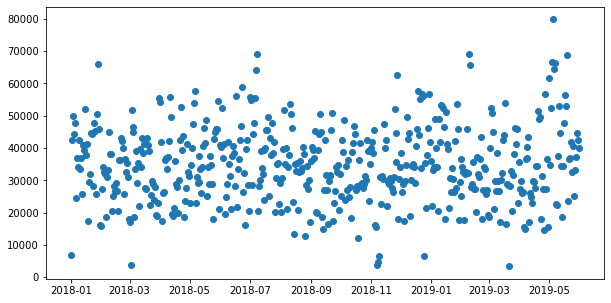

In [134]:
train2 = train_new[train_new["Store_id"] == 1]
train2

plt.scatter(train2.Date,train2.Sales)
plt.show()

In [174]:
train_new.query("Store_id==1")

,Store_Type,Location_Type,Region_Code,Discount,Store_id,Holiday,Sales,Date
0,0,2,0,1,1,1,7011.84,2018-01-01
607,0,2,0,1,1,0,42369.00,2018-01-02
1046,0,2,0,1,1,0,50037.00,2018-01-03
1207,0,2,0,1,1,0,44397.00,2018-01-04
1752,0,2,0,1,1,0,47604.00,2018-01-05
...,...,...,...,...,...,...,...,...
186569,0,2,0,1,1,0,33075.00,2019-05-27
187165,0,2,0,1,1,0,37317.00,2019-05-28
187391,0,2,0,1,1,0,44652.00,2019-05-29
187962,0,2,0,1,1,0,42387.00,2019-05-30


<AxesSubplot:xlabel='Date'>

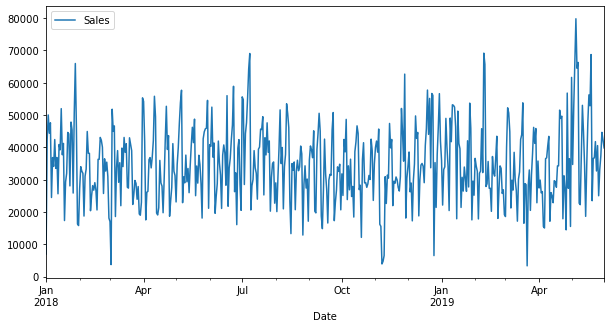

In [109]:
# Updating the header

data1 = train_new[(train_new["Store_id"] == 1)]
data11 = data1[["Sales","Date"]]
data11.columns=["Sales","Date"]

data11 = data11.set_index('Date')

from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
data11.plot()

#### For ARIMA first thing we do is identify if the data is stationary or non – stationary. if data is non-stationary we will try to make them stationary then we will process further.

In [67]:
from statsmodels.tsa.stattools import adfuller

- Ho: It is non-stationary
- H1: It is stationary

We will be considering the null hypothesis that data is not stationary and the alternate hypothesis that data is stationary.

In [177]:
test_result = adfuller(data11['Sales'])

def adfuller_test(sales):
    result = adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("Data is stationary")
    else:
        print("Data is non-stationary ")
        
    

In [112]:
adfuller_test(data11['Sales'])

ADF Test Statistic : -4.089691325020226
p-value : 0.0010072301346594633
#Lags Used : 13
Number of Observations : 502


#### Auto Regressive Model

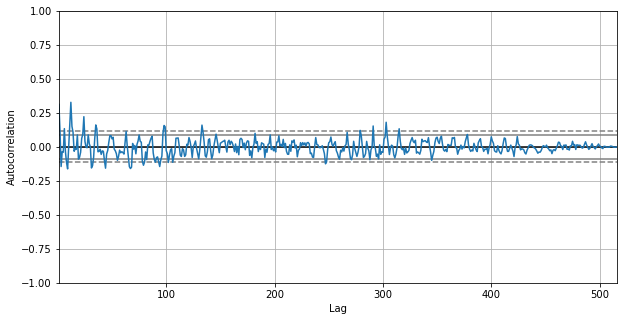

In [114]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(data11['Sales'])
plt.show()

In [115]:
import statsmodels
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

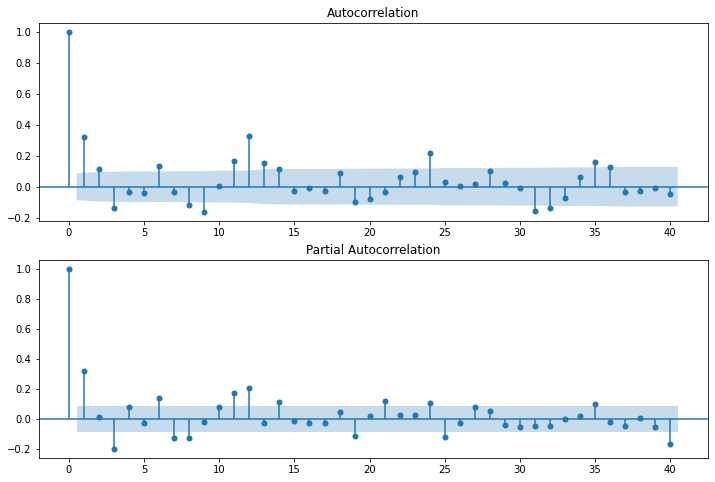

In [116]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data11['Sales'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data11['Sales'].iloc[13:],lags=40,ax=ax2)

In [ ]:
#p = 2 or 1 , q =1 or 0 , d= 0
#Non-seasonal ARIMA models are generally denoted ARIMA(p,d,q) where parameters p, d, and q are non-negative integers,

In [142]:
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings("ignore")

In [154]:
def prediction_for_store(store_id=None, train_new = train_new, test_new = test_new):
    train = train_new[(train_new["Store_id"] == store_id)]
    train = train[["Sales","Date"]]
    train.columns=["Sales","Date"]
    train = train.set_index('Date')
    
    test = test_new[(test_new["Store_id"] == store_id)]
    
    test_result = adfuller(train['Sales'])
    
    start = len(train)
    end = len(train) + len(test) - 1

    p_values = range(1,2)
    d_values = range(0,1)
    q_values = range(0,1)
    
    
    prediction_store = []
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                for i in range(len(test)):
                    try:
                        model=ARIMA(train['Sales'],order)
                        model_fit=model.fit(disp=0)
                        pred_y = model_fit.forecast()[0]
                        prediction_store.append(pred_y)
                    except:
                        continue
    return prediction_store

In [ ]:
predictions = []
for i in range(365):
    pred = prediction_for_store(i+1)
    predictions.append(pred)

In [ ]:
result=[]
for prediction in predictions:
    for data in prediction:
        result.extend(data)
        
len(result)

In [ ]:
frame = { 'ID': test.ID, 'Sales': result}
sub14 = pd.DataFrame(frame)
sub14.set_index('ID', inplace=True)
sub14 = sub14.to_csv("sub14.csv")

#### Finding Outliers:

In [ ]:
out = sns.boxplot(train_new["Sales"])
plt.show()

In [ ]:
Q1 = train_new["Sales"].quantile(0.25)
Q3 = train_new["Sales"].quantile(0.75)
IQR = Q3 - Q1

filter = (train_new["Sales"] >= Q1 - 1.5 * IQR) & (train_new["Sales"] <= Q3 + 1.5 *IQR)
train2 = train_new.loc[filter]  
print("data loss percentage {}%".format(((len(train_new) - len(train2))/len(train_new))*100))
